In [1]:
%matplotlib inline

# General imports

In [2]:
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np
import glob



###Making easy to track results folders
import datetime
year = datetime.date.today().year
month = datetime.date.today().month
import os
figs_dir = '../Results/Figures/{}_{:02}'.format(year, month)
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

# Plotting configuration

In [3]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['axes.titlesize'] = 10

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.5'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.weight']='normal'
matplotlib.rcParams['axes.axisbelow'] = True

# Specific library for funcitons shared across this project

In [4]:
from supporting_functions import *

# Some figures to look at differences between contact definitions for an example protein/s
**First import all distance csv files**

In [5]:
chain_cutoff = 12
CA_distance_cutoff = 8

df_contacts_dict = {}
metrics = ['CA', 'CB', 'SCcenter']
for metric in metrics:
    df_contacts_dict[metric] = {}

total_contacts_via_CA = {}
CB_distance_cutoffs = {}
SC_distance_cutoffs = {}

for metric in metrics[:]:
    for contact_file in glob.glob('../Data/Contact_matrices/*_{}_contacts.csv'.format(metric))[:]:
        prot_name = contact_file.split('/')[-1].split('_')[0]
        total_contacts = 0
        cutoff=0
        df_contacts = pd.read_csv(contact_file, index_col=0)
        df_contacts, df_contacts_stack = process_contacts_df(df_contacts, 12)
        if metric == 'CA':
            total_contacts = df_contacts_stack[df_contacts_stack['distance']<CA_distance_cutoff]['distance'].count()
            total_contacts_via_CA[prot_name] = total_contacts
        else:
            temp = df_contacts_stack.sort_values('distance')[:total_contacts_via_CA[prot_name]]
            cutoff = temp.iloc[total_contacts_via_CA[prot_name]-1]['distance']
            if metric == 'CB':
                CB_distance_cutoffs[prot_name] = cutoff
            elif metric == 'SCcenter':
                SC_distance_cutoffs[prot_name] = cutoff
        df_contacts_dict[metric][prot_name] = (df_contacts, df_contacts_stack)

**Look at all distances/contacts as a heatmap for an example**

In [6]:
prot_name = '1AOE'
vmin = 0
vmax = 50
metric = 'CA'
df_contacts = df_contacts_dict[metric][prot_name][0]

**Leaving in some commented code whose meaning should be obvious and which was used to make slight variations on the figures**

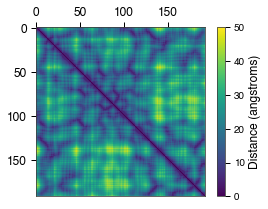

In [7]:
fig, ax = plt.subplots(figsize=(4,3))
cax = ax.matshow(df_contacts.as_matrix(), vmin=vmin, vmax=vmax)
ax.grid(False)
cbar = fig.colorbar(cax)

cbar.set_label('Distance (angstroms)', fontsize=12)
ax.xaxis.tick_top()
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)

plt.tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('{}/{}_{}_contacts.pdf'.format(figs_dir, prot_name, metric), bbox_inches='tight')

**Apply a threshold to only show contacts below a certain distance**

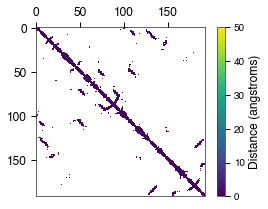

In [8]:
distance_threshold = 8.0
binarized_contacts = df_contacts[df_contacts <= distance_threshold]
binarized_contacts.mask(binarized_contacts <= distance_threshold, other = 1, inplace=True)
fig, ax = plt.subplots(figsize=(4,3))
cax = ax.matshow(binarized_contacts.as_matrix(), vmin=0, vmax=vmax)
cbar = fig.colorbar(cax)
cbar.set_label('Distance (angstroms)', fontsize=12)
ax.grid(False)
ax.xaxis.tick_top()
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('{}/{}_{}_binary.pdf'.format(figs_dir, prot_name, metric), bbox_inches='tight')

**Apply a filter to remove pairs that are closer than X primary a.a's away from one another**

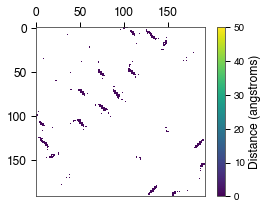

In [9]:
for index in binarized_contacts.index:
    for col in binarized_contacts.columns:
        if abs(index-col) < 12:
            binarized_contacts.set_value(index, col, np.nan)
fig, ax = plt.subplots(figsize=(4,3))
cax = ax.matshow(binarized_contacts.as_matrix(), vmin=vmin, vmax=vmax)
cbar = fig.colorbar(cax)
cbar.set_label('Distance (angstroms)', fontsize=12)
ax.grid(False)
ax.xaxis.tick_top()
plt.tick_params(labelsize=12)
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.tight_layout()
# plt.savefig('{}/{}_{}_binary_truncated.pdf'.format(figs_dir, prot_name, metric), bbox_inches='tight')

# Coupling matrices examples
**Think that these are for presentation purposes only**

In [10]:
df_couplings = pd.read_csv('../Data/Empirical_couplings/1AOE_A_rp75.plmc.processed.couplings', sep=',')
df_couplings_pivot = df_couplings.pivot(index='aa1_loc', columns='aa2_loc', values='couplings').fillna(0)+\
df_couplings.pivot(index='aa2_loc', columns='aa1_loc', values='couplings').fillna(0)

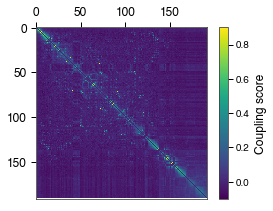

In [11]:
fig, ax = plt.subplots(figsize=(4,3))
cax = ax.matshow(df_couplings_pivot.as_matrix())
ax.grid(False)
cbar = fig.colorbar(cax)
cbar.set_label('Coupling score', fontsize=12)
ax.xaxis.tick_top()
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)

plt.tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('{}/{}_{}_couplings.pdf'.format(figs_dir, prot_name, metric), bbox_inches='tight')

In [12]:
a, b = process_couplings_df(df_couplings, df_contacts, 12)

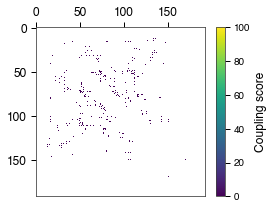

In [13]:
threshold = min(a.sort_values('couplings', ascending=False)[:int(max(a['aa2_loc']))]['couplings'])

df_couplings_pivot = a.pivot(index='aa1_loc', columns='aa2_loc', values='couplings').fillna(0)+\
            a.pivot(index='aa2_loc', columns='aa1_loc', values='couplings').fillna(0)
binary = df_couplings_pivot[df_couplings_pivot > threshold]
binary.mask(binary > threshold, other=1, inplace=True)
fig, ax = plt.subplots(figsize=(4,3))
cax = ax.matshow(binary.as_matrix(), vmin=0, vmax=100)
cbar = fig.colorbar(cax)
cbar.set_label('Coupling score', fontsize=12)
ax.grid(False)
ax.xaxis.tick_top()
plt.locator_params(axis='y', nbins=4)
plt.locator_params(axis='x', nbins=4)
plt.tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('{}/{}_{}_couplings_binary.pdf'.format(figs_dir, prot_name, metric), bbox_inches='tight')

# Structural information for lots of proteins

**These are thresholds that could be used if one wanted to define a "universal" threshold and the corresponding histograms**

In [14]:
np.median(list(CB_distance_cutoffs.values())), np.median(list(SC_distance_cutoffs.values()))

(7.58575963973999, 7.4709632396698)

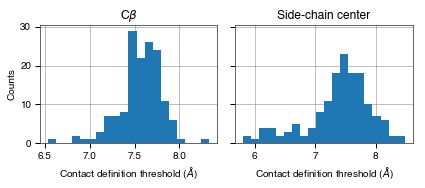

In [15]:
fig, ax_arr = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(6,2.7))
ax_arr[0].hist(list(CB_distance_cutoffs.values()), 20);
ax_arr[1].hist(list(SC_distance_cutoffs.values()), 20);
ax_arr[0].set_ylabel('Counts')

ax_arr[0].set_xlabel(r'Contact definition threshold ($\AA$)')
ax_arr[1].set_xlabel(r'Contact definition threshold ($\AA$)')
ax_arr[0].set_title(r'C$\beta$', fontsize=12)
ax_arr[1].set_title(r'Side-chain center', fontsize=12)
plt.tight_layout()
# plt.savefig('{}/contact_thresholds.pdf'.format(figs_dir), bbox_inches='tight')

## Comparing the correlation of distances and the overlap of contacts between different methods across the protein set

In [16]:
###Choose one
metrics = ['CA', 'SCcenter']
# metrics = ['CB', 'SCcenter']

rho_vals = []
intersection_vals = []
for prot_name in list(df_contacts_dict['CA'].keys())[:]:

    ###Choose one
    initial_dist = 8
#     initial_dist = CB_distance_cutoffs[prot_name]
    
    first_contacts = df_contacts_dict[metrics[0]][prot_name][1].copy()
    second_contacts = df_contacts_dict[metrics[1]][prot_name][1].copy()
    assert all(first_contacts.index == second_contacts.index)
    assert all(first_contacts['aa1_loc'] == second_contacts['aa1_loc'])
    assert all(first_contacts['aa2_loc'] == second_contacts['aa2_loc'])
    first_contacts_trunc = first_contacts[first_contacts['distance'] <= initial_dist]
    totals = len(first_contacts_trunc.index)
    second_contacts_trunc = second_contacts.sort_values('distance')
    second_contacts_trunc = second_contacts_trunc.head(totals)
    second_contacts_trunc.sort_index(inplace=True)
    intersection = len(list(set(first_contacts_trunc.index) & set(second_contacts_trunc.index)))
    rho, pval = stats.spearmanr(first_contacts['distance'], second_contacts['distance'])
    rho_vals.append(rho)
    intersection_vals.append(intersection/totals*100)

150 0.9577355116005049
150 62.58756349390791


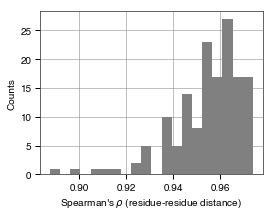

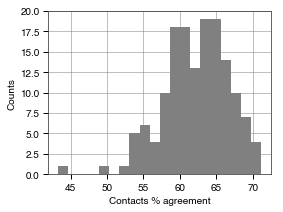

In [17]:
print(len(rho_vals), np.median(rho_vals))
print(len(intersection_vals), np.median(intersection_vals))
fig, ax = plt.subplots(figsize=(4,3))
ax.hist(rho_vals,20, color='gray')
ax.set_xlabel(r"Spearman's $\rho$ (residue-residue distance)")
ax.set_ylabel('Counts')
###Choose one
# plt.savefig('{}/contact_correlation_hist_CA_SC.pdf'.format(figs_dir), bbox_inches='tight')
# plt.savefig('{}/contact_correlation_hist_CB_SC.pdf'.format(figs_dir), bbox_inches='tight')

fig, ax = plt.subplots(figsize=(4,3))
ax.hist(intersection_vals,20, color='gray')
ax.set_xlabel(r"Contacts % agreement")
ax.set_ylabel('Counts')
###Choose one
# plt.savefig('{}/contact_intersection_hist_CA_SC.pdf'.format(figs_dir), bbox_inches='tight')
# plt.savefig('{}/contact_intersection_hist_CB_SC.pdf'.format(figs_dir), bbox_inches='tight')

## Look at those values for a single example protein

In [18]:
example_prot = '1AOE'

###Choose one
# metrics = ['CA', 'SCcenter']
metrics = ['CB', 'SCcenter']

###Choose one
# initial_dist = 8
initial_dist = CB_distance_cutoffs[example_prot]

for prot_name in list(df_contacts_dict['CA'].keys())[:]:
    if prot_name != example_prot:
        continue
    first_contacts = df_contacts_dict[metrics[0]][prot_name][1].copy()
    second_contacts = df_contacts_dict[metrics[1]][prot_name][1].copy()
    assert all(first_contacts.index == second_contacts.index)
    assert all(first_contacts['aa1_loc'] == second_contacts['aa1_loc'])
    assert all(first_contacts['aa2_loc'] == second_contacts['aa2_loc'])
    first_contacts_trunc = first_contacts[first_contacts['distance'] <= initial_dist]
    totals = len(first_contacts_trunc.index)

    second_contacts_trunc = second_contacts.sort_values('distance')
    second_contacts_trunc = second_contacts_trunc.head(totals)
    second_contacts_trunc.sort_index(inplace=True)
    intersection = len(list(set(first_contacts_trunc.index) & set(second_contacts_trunc.index)))
    rho, pval = stats.spearmanr(first_contacts['distance'], second_contacts['distance'])
    print(rho, intersection/len(list(set(first_contacts_trunc.index))))

0.9859868655758482 0.7559322033898305


**These are the relevant distance thresholds used for this example**

In [19]:
CB_distance_cutoffs[example_prot], SC_distance_cutoffs[example_prot]

(7.500936508178711, 7.329545974731445)

In [20]:
plot_df = pd.merge(first_contacts, second_contacts, left_index=True, right_index=True)

**Complicated plot of it all**

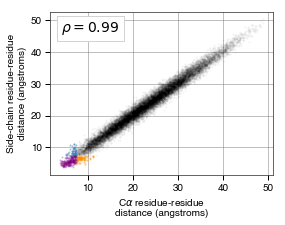

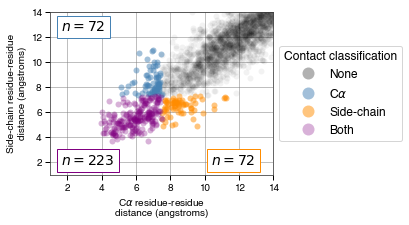

In [21]:
max_axis_lims = 14
x_cutoff = initial_dist
y_cutoff = SC_distance_cutoffs[example_prot]
textstr = r'$\rho={0:2.2f}$'.format(rho)
props = dict(boxstyle='square', facecolor='white', edgecolor='lightgray', alpha=1)

fig, ax = plt.subplots(figsize=(4,3))
subset_df = plot_df[(plot_df['distance_x']>x_cutoff) & (plot_df['distance_y']>y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='k', markeredgewidth=0, markersize=2, alpha=0.05, label='_nolegend_')
ax.plot([], [], 'o', color='k', markeredgewidth=0, markersize=2, alpha=0.3, label=r'None')
subset_df = plot_df[(plot_df['distance_x']<x_cutoff) & (plot_df['distance_y']>y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='steelblue', markeredgewidth=0, markersize=2, alpha=0.5, label=r'C$\alpha$')
subset_df = plot_df[(plot_df['distance_x']>x_cutoff) & (plot_df['distance_y']<y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='darkorange', markeredgewidth=0, markersize=2, alpha=0.5, label=r'Side-chain')
subset_df = plot_df[(plot_df['distance_x']<x_cutoff) & (plot_df['distance_y']<y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='purple', markeredgewidth=0, markersize=2, alpha=0.3, label=r'Both')
ax.set_xlabel(r'C$\alpha$ residue-residue''\n'r'distance (angstroms)')
ax.set_ylabel(r'Side-chain residue-residue''\n'r'distance (angstroms)')
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('{}/{}_distance_scatter.pdf'.format(figs_dir, example_prot), bbox_inches='tight')

fig, ax = plt.subplots(figsize=(4,3))
subset_df = plot_df[(plot_df['distance_x']>x_cutoff) & (plot_df['distance_y']>y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='k', markeredgewidth=0, alpha=0.05, label='_nolegend_')
ax.plot([], [], 'o', color='k', markeredgewidth=0, alpha=0.3, label=r'None')
subset_df = plot_df[(plot_df['distance_x']<x_cutoff) & (plot_df['distance_y']>y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='steelblue', markeredgewidth=0, alpha=0.5, label=r'C$\alpha$')
subset_df = plot_df[(plot_df['distance_x']>x_cutoff) & (plot_df['distance_y']<y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='darkorange', markeredgewidth=0, alpha=0.5, label=r'Side-chain')
subset_df = plot_df[(plot_df['distance_x']<x_cutoff) & (plot_df['distance_y']<y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='purple', markeredgewidth=0, alpha=0.3, label=r'Both')
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title='Contact classification', markerscale=2)
legend.get_title().set_fontsize('12') #legend 'Title' fontsize

ax.set_xlabel(r'C$\alpha$ residue-residue''\n'r'distance (angstroms)')
ax.set_ylabel(r'Side-chain residue-residue''\n'r'distance (angstroms)')
ax.set_xlim(1,max_axis_lims)
ax.set_ylim(1,max_axis_lims)

textstr1 = r'$n={}$'.format(totals-intersection)
props = dict(boxstyle='square', facecolor='white', edgecolor='steelblue', alpha=1)
ax.text(0.05, 0.95, textstr1, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

textstr2 = r'$n={}$'.format(totals-intersection)
props = dict(boxstyle='square', facecolor='white', edgecolor='darkorange', alpha=1)
ax.text(0.72, 0.13, textstr2, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

textstr3 = r'$n={}$'.format(intersection)
props = dict(boxstyle='square', facecolor='white', edgecolor='purple', alpha=1)
ax.text(0.05, 0.13, textstr3, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('{}/{}_contact_scatter.pdf'.format(figs_dir, example_prot), bbox_inches='tight')

**Same plot side by side**

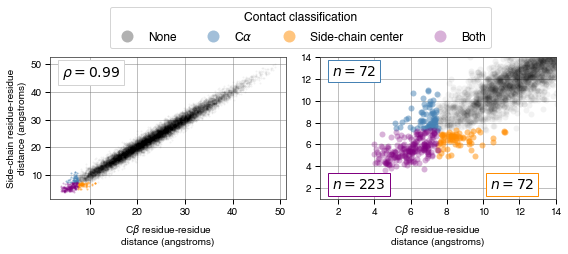

In [22]:
max_axis_lims = 14
x_cutoff = initial_dist
y_cutoff = SC_distance_cutoffs[example_prot]


textstr = r'$\rho={0:2.2f}$'.format(rho)
props = dict(boxstyle='square', facecolor='white', edgecolor='lightgray', alpha=1)

fig, all_ax = plt.subplots(nrows=1, ncols=2,figsize=(8,3))
ax = all_ax[0]
subset_df = plot_df[(plot_df['distance_x']>x_cutoff) & (plot_df['distance_y']>y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='k', markeredgewidth=0, markersize=2, alpha=0.05, label='_nolegend_')
ax.plot([], [], 'o', color='k', markeredgewidth=0, markersize=2, alpha=0.3, label=r'None')
subset_df = plot_df[(plot_df['distance_x']<x_cutoff) & (plot_df['distance_y']>y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='steelblue', markeredgewidth=0, markersize=2, alpha=0.5, label=r'C$\alpha$')
subset_df = plot_df[(plot_df['distance_x']>x_cutoff) & (plot_df['distance_y']<y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='darkorange', markeredgewidth=0, markersize=2, alpha=0.5, label=r'Side-chain center')
subset_df = plot_df[(plot_df['distance_x']<x_cutoff) & (plot_df['distance_y']<y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='purple', markeredgewidth=0, markersize=2, alpha=0.3, label=r'Both')

ax.set_xlabel(r'C$\beta$ residue-residue''\n'r'distance (angstroms)')
ax.set_ylabel(r'Side-chain residue-residue''\n'r'distance (angstroms)')
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


ax = all_ax[1]
subset_df = plot_df[(plot_df['distance_x']>x_cutoff) & (plot_df['distance_y']>y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='k', markeredgewidth=0, alpha=0.05, label='_nolegend_')
ax.plot([], [], 'o', color='k', markeredgewidth=0, alpha=0.3, label=r'None')
subset_df = plot_df[(plot_df['distance_x']<x_cutoff) & (plot_df['distance_y']>y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='steelblue', markeredgewidth=0, alpha=0.5, label=r'C$\alpha$')
subset_df = plot_df[(plot_df['distance_x']>x_cutoff) & (plot_df['distance_y']<y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='darkorange', markeredgewidth=0, alpha=0.5, label=r'Side-chain center')
subset_df = plot_df[(plot_df['distance_x']<x_cutoff) & (plot_df['distance_y']<y_cutoff)]
ax.plot(subset_df['distance_x'], subset_df['distance_y'], 'o', color='purple', markeredgewidth=0, alpha=0.3, label=r'Both')
legend = ax.legend(ncol=4, bbox_to_anchor=(-0.25, 1.02, 1., .102), fontsize=12, title='Contact classification', markerscale=2)
legend.get_title().set_fontsize('12') #legend 'Title' fontsize

###Choose one
# ax.set_xlabel(r'C$\alpha$ residue-residue''\n'r'distance (angstroms)')
ax.set_xlabel(r'C$\beta$ residue-residue''\n'r'distance (angstroms)')

ax.set_xlim(1,max_axis_lims)
ax.set_ylim(1,max_axis_lims)

textstr1 = r'$n={}$'.format(totals-intersection)
props = dict(boxstyle='square', facecolor='white', edgecolor='steelblue', alpha=1)
ax.text(0.05, 0.95, textstr1, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

textstr2 = r'$n={}$'.format(totals-intersection)
props = dict(boxstyle='square', facecolor='white', edgecolor='darkorange', alpha=1)
ax.text(0.72, 0.15, textstr2, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

textstr3 = r'$n={}$'.format(intersection)
props = dict(boxstyle='square', facecolor='white', edgecolor='purple', alpha=1)
ax.text(0.05, 0.15, textstr3, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.tight_layout()

###Choose one
# plt.savefig('{}/{}_scatter_combined_CA_SC.pdf'.format(figs_dir, example_prot), bbox_inches='tight')
# plt.savefig('{}/{}_scatter_combined_CB_SC.pdf'.format(figs_dir, example_prot), bbox_inches='tight')

# Scratch